# Estudo da Fotocorrente, Absorção, Reflexão e Transmissão em Heteroestruturas Semicondutora

Aqui vamos analizar a heteroestrutura proposta por Degani et al [1].

## Bibliotecas utilizadas

In [1]:
import os
import time
import re
from multiprocessing import Pool, TimeoutError
from datetime import datetime

import numpy as np
import pandas as pd

from scipy import constants as cte
from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import expit
from scipy import constants as cte
from scipy.integrate import simps
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.signal import gaussian
from scipy.special import legendre, expit
from scipy.fftpack import fft, ifft, fftfreq
from scipy.spatial.distance import cdist

## Configuração Estética

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 11.7, 8.27
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 16
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = "serif"
# plt.rcParams['font.serif'] = "cm"

## Constantes e Definições

In [3]:
# dataframe de pandas com valores utilizados para calculos
device = pd.DataFrame()

N = 1024  # tamanho padrao do grid
L = 1000.0  # tamanho padrao do sistema em angstrom
dt = 1e-17  # incremento de tempo padrao em segundos
device['z_ang'] = np.linspace(-L/2, L/2, N)  # malha espacial em angstrom

# fatores de conversao para unidades atomicas
au_l = cte.value('atomic unit of length')
au_t = cte.value('atomic unit of time')
au_e = cte.value('atomic unit of energy')
au_v = cte.value('atomic unit of electric potential')
hbar_au = 1.0
me_au = 1.0

# constantes fisicas
ev = cte.value('electron volt')
c = cte.value('speed of light in vacuum')
me = cte.value('electron mass')
q = cte.value('elementary charge')
hbar_ev = cte.value('Planck constant over 2 pi in eV s')
hbar = cte.value('Planck constant over 2 pi')
h = cte.value('Planck constant')

# conversoes rapidas
au2ev = au_e / ev  # unidades atomicas para eV
au2ang = au_l / 1e-10  # unidades atomicas para angstrom

## Perfil do Potencial



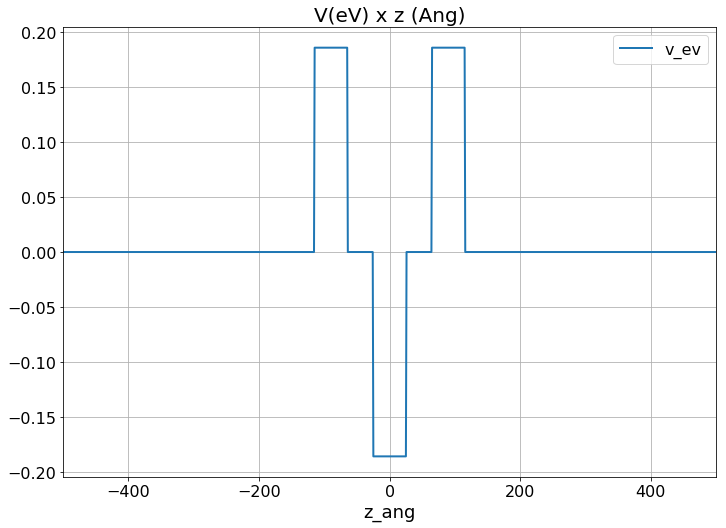

In [4]:
def algaas_gap(x):
    """Retorna o gap do material ja calculado em funcao da fracao de Aluminio
    utilizamos os valores exatos utilizados pelos referidos autores

    Params
    ------
    x : float
        a fracao de aluminio, entre 0 e 1

    Returns
    -------

    O gap em eV
    """
    if x == 0.2:
        return 0.0
    elif x == 0.4:
        return 0.185897
    return -0.185897


def algaas_meff(x):
    """Retorna a massa efetiva do AlGaAs em funcao da fracao de Aluminio
    assim como os referidos autores, utilizamos a massa efetiva do 
    eletron no GaAs ao longo de todo o material

    Params
    ------
    x : float
        a fracao de aluminio, entre 0 e 1

    Returns
    -------

    A massa efetiva do eletron no AlGaAs
    """
    return 0.067


def x_shape(z):
    """Utilizamos a concentracao de Aluminio para determinar o perfil do
    potencial

    Params
    ------

    z : float
        posicao no eixo z em angstrom

    Returns
    -------

    A concentracao de Aluminio na posicao informada
    """
    # concentracoes e larguras do sistema
    xd = 0.2  # concentracao no espaco entre poco e barreira
    xb = 0.4  # concentracao na barreira
    xw = 0.0  # concentracao no poco
    wl = 50.0  # largura do poco em angstrom
    bl = 50.0  # largura da barreira em angstrom
    dl = 40.0  # espacao entre poco e barreira em angstrom

    if np.abs(z) < wl/2:
        return xw
    elif np.abs(z) < wl/2+dl:
        return xd
    elif np.abs(z) < wl/2+dl+bl:
        return xb
    return xd


device['x'] = device['z_ang'].apply(x_shape)
device['v_ev'] = device['x'].apply(algaas_gap)
device['meff'] = device['x'].apply(algaas_meff)

pb = list(device['v_ev']).index(0.185897)  # pontos antes do dispositivo
pa = N-1-pb  # pontos depois do dispositivo

dc = device.plot(x='z_ang', y='v_ev', grid=True, title='V(eV) x z (Ang)')

## Aplicando campo estático

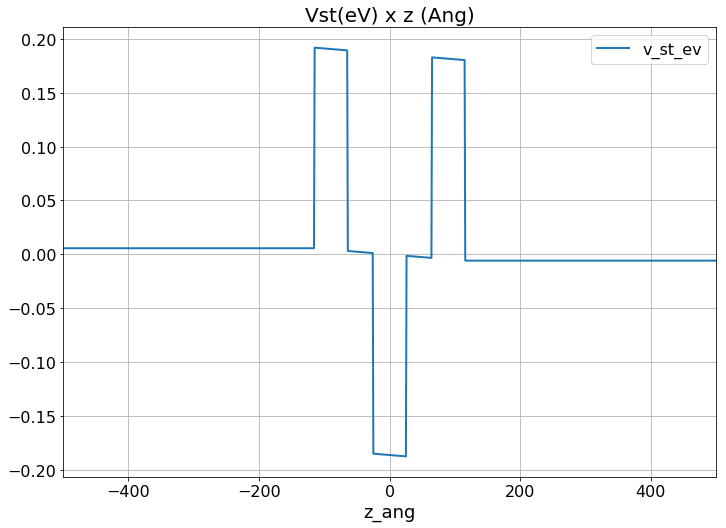

In [5]:
bias = 5.0  # KV/cm
bias_v_cm = bias * 1e3
bias_v_m = 1e2 * bias_v_cm
bias_j_m = bias_v_m * q


def derivada_muda_pct(x, y, n=10, pct=0.05):
    """encontra o ponto x onde a derivada de y(x) muda mais do que uma 
    certa porcentagem pela primeira vez, da esquerda para a direita

    Params
    ------
    x : array_like
        um array com os valores em x
    y : array_like
        um array com os valores em y
    n : int
        numero do pontos para ignorar nas bordas
    pct : float
        a porcentagem da derivada que deve mudar

    Returns
    -------

    O indice do ponto x onde dy/dx muda mais do que pct
    """
    der_y = np.array(y[2:]-y[:-2])/np.array(x[2:]-x[:-2])
    for i in range(n, len(der_y)):
        last_n = np.average(der_y[i-n:i-1])
        if last_n == 0 and der_y[i] != 0 \
                or last_n != 0 and np.abs(der_y[i]/last_n-1) > pct:
            return i
    return int(len(y)/3)


def __constroi_bias(z):
    """constroi o potencial estatico usado como bias/vies, nao usar fora desta
    celula

    Params
    ------

    z : float
        uma posicao no grid em angstrom

    Returns
    -------

    O bias na posicao indicada
    """
    border_left = device['z_ang'].values[pb]
    border_right = device['z_ang'].values[pa]

    def f_st_ev(z): return -(z*1e-10)*(bias_j_m)/ev

    if z <= border_left:
        return f_st_ev(border_left)
    elif z >= border_right:
        return f_st_ev(border_right)
    return f_st_ev(z)


device['bias_ev'] = device['z_ang'].apply(__constroi_bias)
device['v_st_ev'] = device['v_ev']+device['bias_ev']

dc = device.plot(x='z_ang', y='v_st_ev', grid=True, title='Vst(eV) x z (Ang)')

## Modificando alguns vetores para Unidades Atômicas

In [6]:
device['z_au'] = device['z_ang'].apply(lambda z: z / au2ang)
device['v_au'] = device['v_st_ev'].apply(lambda z: z / au2ev)
dt_au = dt / au_t

## Calculando Autovalores e Autovetores

Vamos utilizar o método da interação inversa para gerar os autovalores e autovetores. Quando o potencial estático é aplicado, dentro das condições do sistema, encontramos somente o estado fundamental.

In [7]:
def idf(v, i):
    """Indice flexivel. Por exemplo, i pode ser 1.5 e o resultado sera entao
    (v[2]+v[1])/2

    Params
    ------

    v : array_like
        um vetor
    i : float
        um indice flexivel

    Returns
    -------

    Uma interpolacao simples de v para o indice flexivel i
    """
    i_up = int(np.ceil(i))
    i_down = int(np.floor(i))
    if i_down < 0.0:
        return v[0]
    elif i_up >= len(v) - 1:
        return v[-1]
    return (v[i_up]+v[i_down])/2.0


def eigenvalue(z, V, psi, m):
    """Calcula um autovalor como E=<Psi|H|Psi>/<Psi|Psi>
    onde H = T + V, T eh o operador de energia cinetica em uma dimensao

    Params
    ------

    z : array_like
        o eixo z
    V : array_like
        o potencial
    psi : array_like
        a funcao de onda psi(z)
    m : array_like
        a massa efetiva m*(z)

    Returns
    -------

    O autovalor E=<Psi|H|Psi>/<Psi|Psi>
    """
    dz = np.append(z[1:]-z[:-1], z[1]-z[0])
    dz2 = dz**2
    h_psi = np.zeros(N, dtype=np.complex_)

    for i in range(N):
        h_psi[i] = ((0.5/dz2[i])*(1.0/idf(m, i+0.5) +
                                  1.0/idf(m, i-0.5))+V[i])*psi[i]
        if i > 0:
            h_psi[i] += -(0.5/dz2[i])*(psi[i-1]/idf(m, i-0.5))
        if i < N-1:
            h_psi[i] += -(0.5/dz2[i])*(psi[i+1]/idf(m, i+0.5))

    psi_h_psi = simps(psi.conj()*h_psi, z)
    return (psi_h_psi / simps(psi.conj()*psi, z)).real


def chutes_iniciais(n=2, size=1024, mu=None):
    """Retorna os n primeiros polinomios de legendre modulados por uma
    gaussiana. 

    Params
    ------

    n : int
        o numero de vetores
    size : int
        o tamanho dos vetores
    mu : float
        centro da gaussiana, entre 0 e 1

    Returns
    -------

    Um array com n arrays contendo os polinomios modulados
    """
    sg = np.linspace(-1, 1, size)  # short grid
    g = gaussian(size, std=int(size/100))  # gaussian
    if mu:
        sigma = np.ptp(sg)/100
        g = (1.0/np.sqrt(2*np.pi*sigma**2))*np.exp(-(sg-mu)**2 / (2*sigma**2))
    vls = [g*legendre(i)(sg) for i in range(n)]
    return np.array(vls, dtype=np.complex_)


precision = 1e-9  # precisao a ser usada para calculos numericos
nmax = 20  # numero maximo de intervalos

#
forecast = np.linspace(device['v_au'].min(), device['v_au'].max(), nmax)
dz = device['z_au'][1]-device['z_au'][0]
dz2 = dz**2

# chutes iniciais
eigenstates = chutes_iniciais(nmax, size=N)
eigenvalues = np.zeros(nmax)

counters = np.zeros(nmax)
timers = np.zeros(nmax)
precisions = np.zeros(nmax)
vectors_sqeuclidean = np.zeros(nmax)

V = device['v_au'].values
m = device['meff'].values
z = device['z_au'].values

for s in range(nmax):
    last_ev = 1.0  # autovalor inicial fake
    last_es = np.zeros(N, dtype=np.complex_)  # autovetor inicial
    shift = forecast[s]

    # Desloca o potencial do Hamiltoniano por shift
    sub_diag = np.zeros(N-1, dtype=np.complex_)
    main_diag = np.zeros(N, dtype=np.complex_)

    # constroi as diagnais da matriz, a principal e as duas semi
    # principais
    for i in range(N):
        try:
            main_diag[i] = (0.5/dz2)*(1.0/idf(m, i+0.5) +
                                      1.0/idf(m, i-0.5))+(V[i]-shift)
        except:
            main_diag[i] = 0.0

        if i < N-1:
            sub_diag[i] = -(0.5/dz2)*(1.0/idf(m, i+0.5))

    diagonals = [main_diag, sub_diag, sub_diag]
    A = diags(diagonals, [0, -1, 1]).toarray()

    invA = inv(A)

    V_shifted = V-shift

    while True:
        start_time = time.time()
        eigenstates[s] = invA.dot(eigenstates[s])
        counters[s] += 1

        # normaliza
        A = np.sqrt(simps(eigenstates[s]*eigenstates[s].conj(), z))
        eigenstates[s] /= A
        timers[s] += time.time() - start_time

        eigenvalues[s] = eigenvalue(z, V_shifted, eigenstates[s], m) + shift

        # confere precisao
        precisions[s] = np.abs(1-eigenvalues[s]/last_ev)
        last_ev = eigenvalues[s]

        if precisions[s] < precision:
            XA = [np.abs(eigenstates[s])**2]
            XB = [np.abs(last_es)**2]
            vectors_sqeuclidean[s] = cdist(XA, XB, 'sqeuclidean')[0][0]
            break

        last_es = np.copy(eigenstates[s])

sort_index = eigenvalues.argsort()
eigenvalues = eigenvalues[sort_index]
eigenstates = eigenstates[sort_index]

iz_left = derivada_muda_pct(z, V)
iz_right = len(V)-derivada_muda_pct(z, V[::-1])
golden_ones = [0]

for i in range(eigenvalues.size):
    # remove estados repetidos e nao confinados
    if i == 0 or np.abs(eigenvalues[i]/eigenvalues[i-1]-1) < 0.1 \
            or eigenvalues[i] > np.max(V):
        continue

    # remove os estados nao confinados lateralmente
    state = eigenstates[i].copy()
    state_l = state[:iz_left]
    state_m = state[iz_left:iz_right]
    state_r = state[iz_right:]
    int_left = simps(state_l*state_l.conj(), z[:iz_left]).real
    int_mid = simps(state_m*state_m.conj(), z[iz_left:iz_right]).real
    int_right = simps(state_r*state_r.conj(), z[iz_right:]).real

    if int_left+int_right > int_mid:
        continue

    golden_ones.append(i)

eigenvalues = eigenvalues[golden_ones] * au2ev
eigenstates = eigenstates[golden_ones]
counters = counters[golden_ones]
timers = timers[golden_ones]
precisions = precisions[golden_ones]
squared_euclidean_dist = vectors_sqeuclidean[golden_ones]

for i, state in enumerate(eigenstates):
    AN = np.sqrt(simps(state.conj() * state, device['z_ang']))
    device['state_%d' % i] = state / AN

## Fotocorrente

In [35]:
def fotocorrente(energy, fosc=5.0, T=1e-12):
    """Calcula a fotocorrente para uma dada energia em eV (do campo eletrico)

    Params
    ------

    energy : float
        energia dos fotons incidentes em eV
    fosc : float
        intensidade do potencial oscilante em KV/cm
    T : float
        tempo total de evolucao em segundos

    Returns
    -------

    A fotocorrente 
    """

    fosc_j_m = fosc * 1e2 * 1e3 * q  # KV/cm -> J/m
    T_au = T / au_t
    iters = int(T_au / dt_au)
    t_grid_au = np.linspace(0.0, T_au, iters)

    psi = np.array(device.state_0, dtype=np.complex_)
    psi /= np.sqrt(simps(psi*psi.conj(), device.z_au))

    meff = device['meff'].values
    z_au = device['z_au'].values
    dz_au = z_au[1]-z_au[0]
    k_au = fftfreq(N, d=dz_au)
    j_t = np.zeros(iters)

    def j_p(p):
        """J=1/(2 i m*) (psi* d(psi)/dz - psi d(psi*)/dz) """
        dzp = z_au[p+1]-z_au[p-1]
        pcdp = psi[p].conj() * (psi[p+1]-psi[p-1]) / dzp
        pdpc = psi[p] * (psi[p+1].conj()-psi[p-1].conj()) / dzp
        return ((-0.5j/(meff[p])) * (pcdp-pdpc)).real

    absorbing = device['z_ang'].apply(
        lambda z: min(expit((450-z)/5), expit((z+450)/5)))

    z0_ang = device['z_ang'].values[0]
    fosc_j = device['z_ang'].apply(lambda z: (z0_ang-z) * 1e-10 * fosc_j_m)
    fosc_ev = fosc_j / ev
    fosc_au = fosc_ev / au2ev

    omega_au = (energy / au2ev) / hbar_au

    v_au_ti = device['v_au'].values
    exp_t = np.exp(- 0.5j * (2 * np.pi * k_au) ** 2 * dt_au / meff)
    #exp_v2h = np.exp(- 0.5j * v_au_ti * dt_au)
    exp_v2h = np.exp(- 1.0j * v_au_ti * dt_au)

    #f_espec = - 0.5j * fosc_au * dt_au
    f_espec = - 1.0j * fosc_au * dt_au

#     timer_alloc = 0.0
#     timer_evolv = 0.0
#     timer_photo = 0.0

    for i, t_au in enumerate(t_grid_au):

        #         0.00070253
        #         0.00034932
        #         0.00024019

        #         0.00046501
        #         0.00036087
        #         0.00024645

        #         0.00044523
        #         0.00034345
        #         0.00023177

        #         0.00042110
        #         0.00018084
        #         0.00003180
        
        #start_time = time.time()
        exp_v2 = exp_v2h * np.exp(f_espec * np.sin(omega_au*t_au))
        #timer_alloc += time.time() - start_time

        #start_time = time.time()
        #psi = exp_v2 * ifft(exp_t * fft(exp_v2 * psi)) * absorbing
        psi = ifft(exp_t * fft(exp_v2 * psi)) * absorbing
        #timer_evolv += time.time() - start_time

        #start_time = time.time()
        j_t[i] = j_p(pb-100)-j_p(pa+100)
        #timer_photo += time.time() - start_time

#         if i % 10000 == 0 and i > 0:
#             evolved = psi.copy()
#             evolved /= np.sqrt(simps(np.conjugate(psi)*psi, device['z_ang'].values))
#             device['state_0_evolved'] = evolved
#             device['state_0_evolved_norm'] = (np.abs(evolved)**2).real
#             device.plot(x='z_ang', y=['v_ev', 'state_0_evolved_norm'])
#             plt.plot()

#     print("Alocando: %.8f s" % (timer_alloc/t_grid_au.size))
#     print("Evoluindo: %.8f s" % (timer_evolv/t_grid_au.size))
#     print("Corrente: %.8f s" % (timer_photo/t_grid_au.size))

    return q * (simps(j_t, t_grid_au) / T_au) / T

In [36]:
energies = np.linspace(0.1, 0.4, 300) # energy from 100 meV to 400 meV
photocurrent = []
def get_pc(energy):
    pc = fotocorrente(energy=energy)
#     now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#     print("[%s] > Energy: %.6f eV, PC: %.6e " % (now, energy, pc))
    return pc
pool = Pool(processes=4)
photocurrent = pool.map(get_pc, energies)

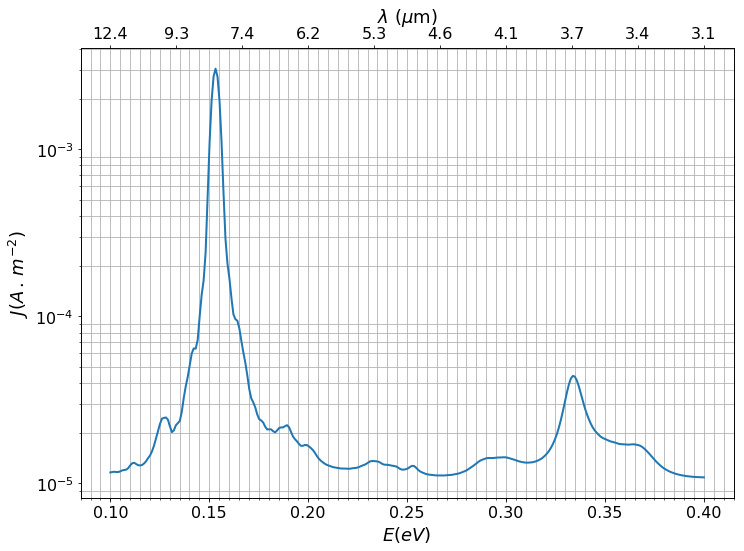

In [37]:
fig, ax = plt.subplots()

ax.set_xlabel(r'$E (eV)$')
ax.set_ylabel(r'$J (A\, .\, {m}^{-2})$')
ax.semilogy(energies, -np.array(photocurrent)*1e10)

ax2 = ax.twiny()
tiny_energies = np.linspace(0.1, 0.4, 10)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(tiny_energies)
ax2.set_xticklabels(["%.1f" % ((h * c / (e * ev))/1e-6) for e in tiny_energies])
ax2.set_xlabel(r"$\lambda$ ($\mu$m)")

minorLocator_x = MultipleLocator(0.005)
ax.xaxis.set_minor_locator(minorLocator_x)
ax.grid(which = 'minor')
plt.show()

## Absorção

In [ ]:
def absorcao(energy, T=1e-12):
    """Calcula a absorcao para uma dada energia em eV (do campo eletrico)

    Params
    ------

    energy : float
        energia dos fotons incidentes em eV
    fosc : float
        intensidade do potencial oscilante em KV/cm
    T : float
        tempo total de evolucao em segundos

    Returns
    -------

    A fotocorrente 
    """

    fosc_j_m = fosc * 1e2 * 1e3 * q  # KV/cm -> J/m
    T_au = T / au_t
    iters = int(T_au / dt_au)
    t_grid_au = np.linspace(0.0, T_au, iters)

    psi = np.array(device.state_0, dtype=np.complex_)
    psi /= np.sqrt(simps(psi*psi.conj(), device.z_au))

    meff = device['meff'].values
    z_au = device['z_au'].values
    dz_au = z_au[1]-z_au[0]
    k_au = fftfreq(N, d=dz_au)
    j_t = np.zeros(iters)

    def j_p(p):
        """J=1/(2 i m*) (psi* d(psi)/dz - psi d(psi*)/dz) """
        dzp = z_au[p+1]-z_au[p-1]
        pcdp = psi[p].conj() * (psi[p+1]-psi[p-1]) / dzp
        pdpc = psi[p] * (psi[p+1].conj()-psi[p-1].conj()) / dzp
        return ((-0.5j/(meff[p])) * (pcdp-pdpc)).real

    absorbing = device['z_ang'].apply(
        lambda z: min(expit((450-z)/5), expit((z+450)/5)))

    z0_ang = device['z_ang'].values[0]
    fosc_j = device['z_ang'].apply(lambda z: (z0_ang-z) * 1e-10 * fosc_j_m)
    fosc_ev = fosc_j / ev
    fosc_au = fosc_ev / au2ev

    omega_au = (energy / au2ev) / hbar_au

    v_au_ti = device['v_au'].values
    exp_t = np.exp(- 0.5j * (2 * np.pi * k_au) ** 2 * dt_au / meff)
    #exp_v2h = np.exp(- 0.5j * v_au_ti * dt_au)
    exp_v2h = np.exp(- 1.0j * v_au_ti * dt_au)

    #f_espec = - 0.5j * fosc_au * dt_au
    f_espec = - 1.0j * fosc_au * dt_au

    for i, t_au in enumerate(t_grid_au):
        exp_v2 = exp_v2h * np.exp(f_espec * np.sin(omega_au*t_au))
        psi = ifft(exp_t * fft(exp_v2 * psi))
        
        j_t[i] = j_p(pb-100)-j_p(pa+100)

    return q * (simps(j_t, t_grid_au) / T_au) / T

In [38]:
device

,z_ang,x,v_ev,meff,bias_ev,v_st_ev,z_au,v_au,state_0
0,-500.000000,0.2,0.0,0.067,0.005743,0.005743,-944.863063,0.000211,(6.55065985997e-13+0j)
1,-499.022483,0.2,0.0,0.067,0.005743,0.005743,-943.015823,0.000211,(1.311451534e-12+0j)
2,-498.044966,0.2,0.0,0.067,0.005743,0.005743,-941.168584,0.000211,(1.9704788616e-12+0j)
3,-497.067449,0.2,0.0,0.067,0.005743,0.005743,-939.321344,0.000211,(2.6334755029e-12+0j)
4,-496.089932,0.2,0.0,0.067,0.005743,0.005743,-937.474104,0.000211,(3.3017769801e-12+0j)
5,-495.112414,0.2,0.0,0.067,0.005743,0.005743,-935.626865,0.000211,(3.97672949124e-12+0j)
6,-494.134897,0.2,0.0,0.067,0.005743,0.005743,-933.779625,0.000211,(4.65969261929e-12+0j)
7,-493.157380,0.2,0.0,0.067,0.005743,0.005743,-931.932385,0.000211,(5.35204206823e-12+0j)
8,-492.179863,0.2,0.0,0.067,0.005743,0.005743,-930.085146,0.000211,(6.05517243157e-12+0j)
9,-491.202346,0.2,0.0,0.067,0.005743,0.005743,-928.237906,0.000211,(6.77049999877e-12+0j)
